# Hierarchical Forecast Networks

XXX

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/HierarchicalNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Libraries

In [1]:
# %%capture
# !pip install git+https://github.com/Nixtla/neuralforecast.git

In [2]:
# %%capture
# !pip install datasetsforecast hierarchicalforecast

## 2. Load data

In [3]:
import pandas as pd
from datasetsforecast.hierarchical import HierarchicalData
import matplotlib.pyplot as plt

def sort_df_hier(Y_df, S):
    Y_df.unique_id = Y_df.unique_id.astype('category')
    Y_df.unique_id = Y_df.unique_id.cat.set_categories(S.index)
    Y_df = Y_df.sort_values(by=['unique_id', 'ds'])

    return Y_df

# Load TourismSmall dataset
Y_df, S_df, tags = HierarchicalData.load('./data', 'TourismLarge')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

Y_df = sort_df_hier(Y_df, S_df)

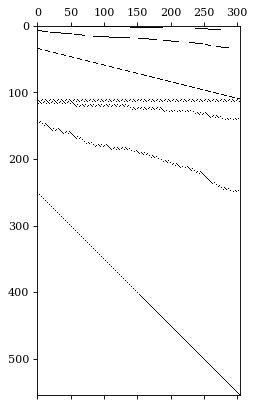

In [4]:
from hierarchicalforecast.utils import aggregate, HierarchicalPlot

hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

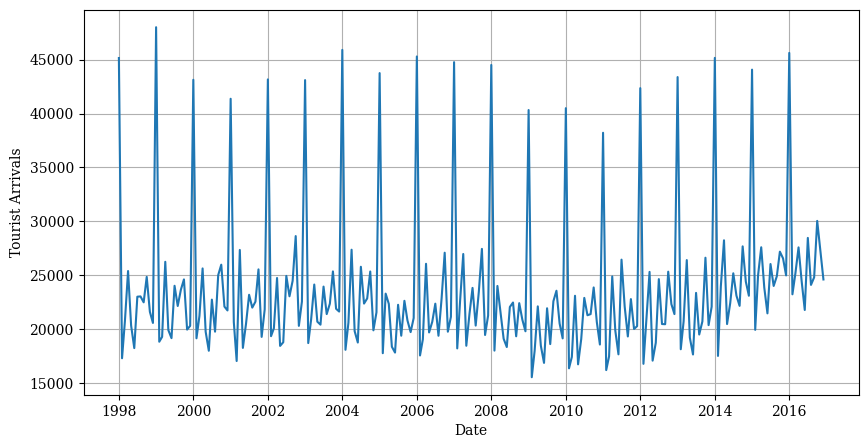

In [5]:
plt.figure(figsize=(10,5))
plt.plot(Y_df[Y_df['unique_id']=='TotalAll']['ds'], Y_df[Y_df['unique_id']=='TotalAll']['y'])
plt.xlabel('Date')
plt.ylabel('Tourist Arrivals')
plt.grid()

## 3. Training

In [6]:
import numpy as np

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS, HINT
from neuralforecast.losses.pytorch import GMM

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Horizon and quantiles
horizon = 12
level = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] for lv in level]
quantiles = np.sort(np.concatenate(qs)/100)

# Base model
nhits = NHITS(h=horizon,
             input_size=24,
             loss=GMM(n_components=10, quantiles=quantiles),
             max_steps=1000,
             early_stop_patience_steps=3,
             val_check_steps=100,
             scaler_type='robust',
             learning_rate=1e-3)

# HINT := Network + Distribution + Reconciliation
model = HINT(h=horizon, model=nhits, S=S_df.values, reconciliation='MinTraceOLS')

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/rp/97y9_3ns23v01hdn0rp9ndw40000gp/T/tmpq6v8iixa
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/rp/97y9_3ns23v01hdn0rp9ndw40000gp/T/tmpq6v8iixa/_remote_module_non_scriptable.py


In [8]:
%%capture
fcst = NeuralForecast(models=[model], freq='MS')
forecasts = fcst.cross_validation(df=Y_df, val_size=12, n_windows=1)

[]

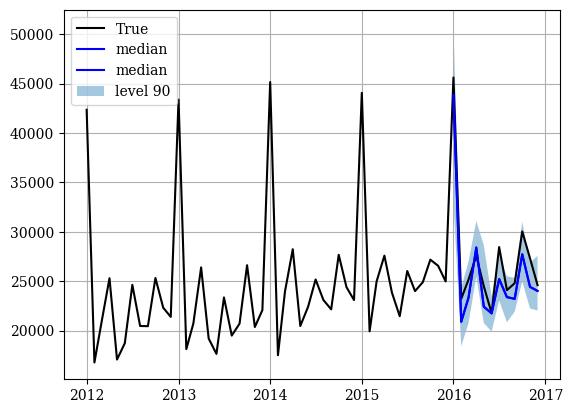

In [9]:
unique_id = 'TotalAll'
Y_plot_df = Y_df[Y_df.unique_id==unique_id].tail(12*5)
plot_df = forecasts[forecasts.unique_id==unique_id]
plot_df = Y_plot_df.merge(plot_df, on=['ds', 'unique_id'], how='left')

plt.plot(plot_df['ds'], plot_df['y_x'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['HINT-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:],
                 y1=plot_df['HINT-lo-90.0'][-12:].values,
                 y2=plot_df['HINT-hi-90.0'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

## Evaluation

In [10]:
from hierarchicalforecast.evaluation import scaled_crps

In [11]:
n_series = len(S_df)
n_quantiles = len(quantiles)

quantiles_columns = nhits.loss.output_names
y_rec = forecasts.iloc[:, 3:-1].values
y_test = forecasts['y'].values

y_rec = y_rec.reshape(n_series, horizon, n_quantiles)
y_test = y_test.reshape(n_series, horizon)

scaled_crps(y=y_test, y_hat=y_rec, quantiles=quantiles)

0.1319950643310924